# Benefits of Ring Averaging
A we move farther from the source, the photon count drops exponentially, which leads to lower SNR and higher variance. We average rings of detectors at each SDD instead of a single one to improve SNR and reduce variance. This notebook shows the effects of before and after using rings! 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from inverse_modelling_tfo.tools.name_decoder import decode_extended_filename
from inverse_modelling_tfo.tools.s_based_intensity_datagen import MU_MAP_BASE1, MU_MAP_BASE2, get_mu_a
from inverse_modelling_tfo.data import EQUIDISTANCE_DETECTOR_COUNT, EQUIDISTANCE_DETECTOR_PHOTON_COUNT
from tfo_sensitivity.data import load_raw

# Pre-calculated intensity using the regular formula (inner product)
maternal_wall_thickness, uterus_thickness, wave_int = 26, 5, 1
raw_sim_data_path = load_raw(maternal_wall_thickness, uterus_thickness, wave_int)
raw_sim_data = pd.read_pickle(raw_sim_data_path)
raw_sim_data['SDD'] = raw_sim_data['X'] - 100
all_sdd = raw_sim_data["SDD"].unique()
all_sdd.sort()

## Hacks
My code does not keep track of individual detectors inside the ring separately. IDs are assigned per ring and not per detector. Which means there is no way to back trace what would happen if we had a single detector per ring compared to the current multi-detector setup. 

But, we can always be sneaky and pick a subset of photons arbitrarily to calculate intensity. Let's say some ring has 20 detectors. We create a subset by picking 1/20-th of all photons and calculate intensity off of that.   

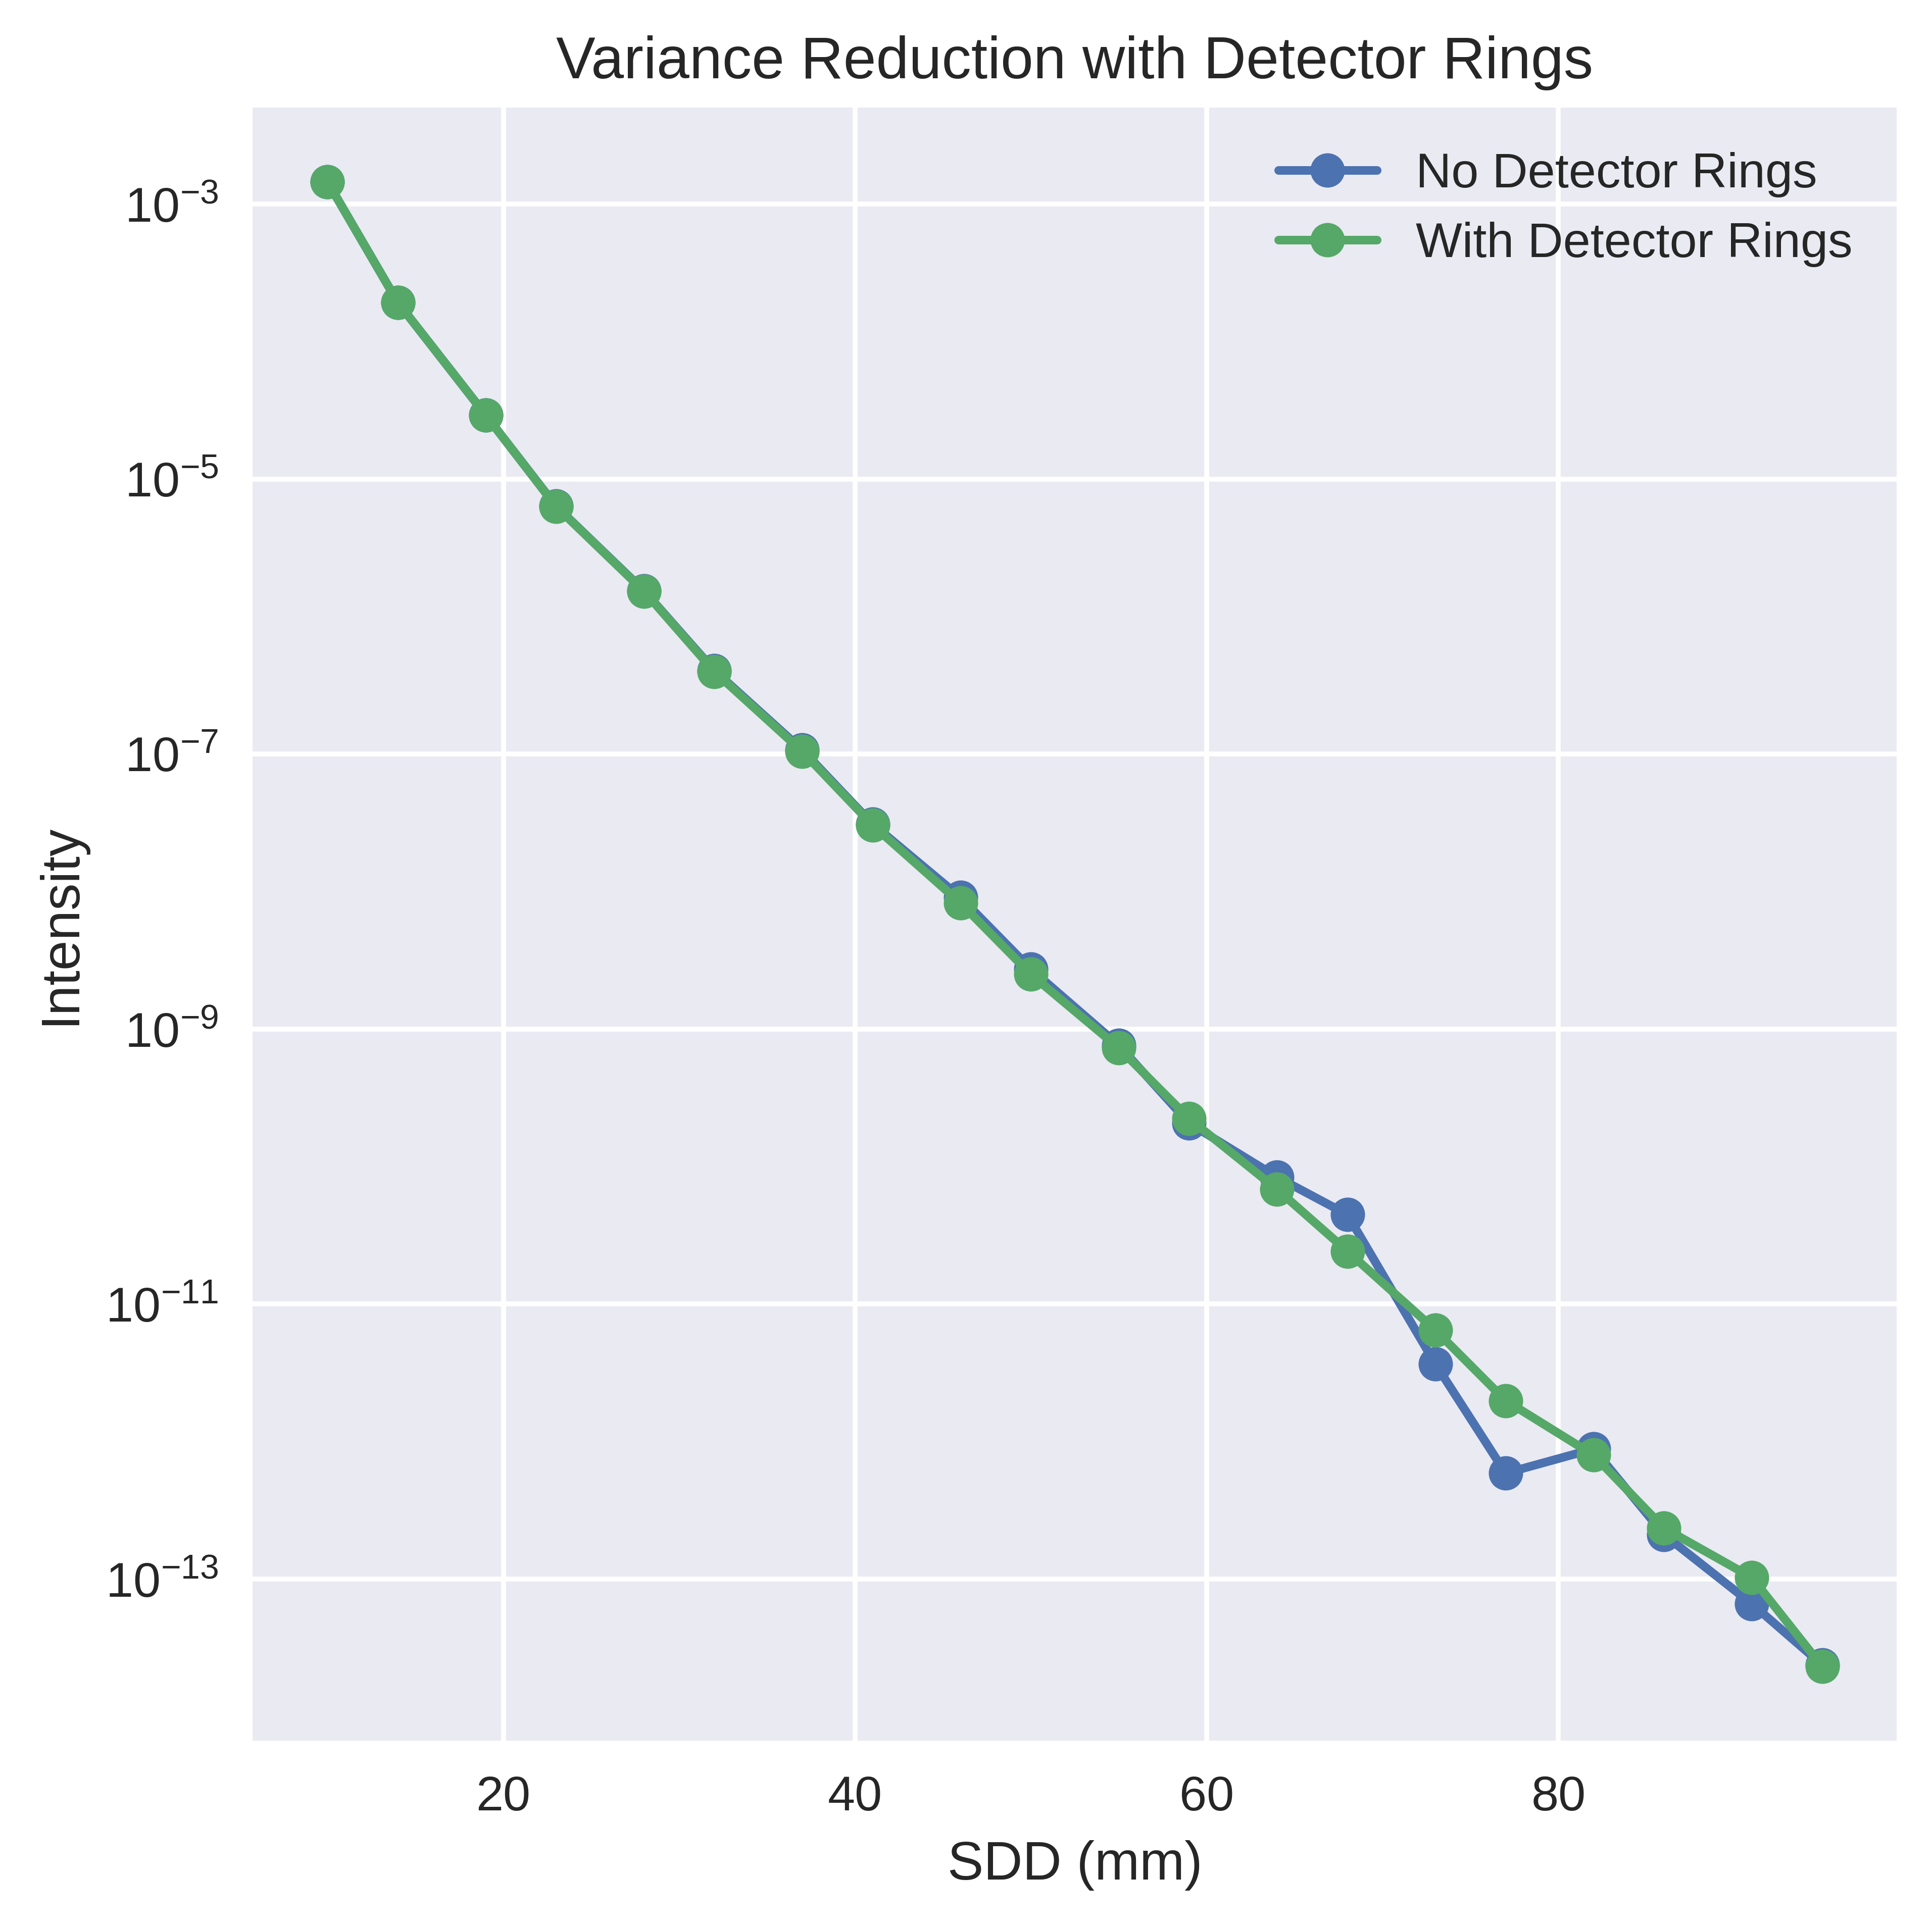

In [11]:
FETAL_SAT = 0.6
FETAL_Hb = 1.2
MATERNAL_SAT = 1.0
MATERNAL_Hb = 1.0

modified_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2
modified_mu_map[4] = get_mu_a(FETAL_SAT, FETAL_Hb, wave_int)
modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)


all_intensity_after = []
all_intensity_before = []
photon_count = []   # Variance \prop sqrt(count)

for sdd_index, sdd in enumerate(all_sdd):
    filtered_photon_data = raw_sim_data[raw_sim_data['SDD'] == sdd]
    photon_count.append(len(filtered_photon_data))
    G = filtered_photon_data[['L1 ppath',
                                'L2 ppath', 'L3 ppath']].to_numpy()
    for i in range(1, 4):
        G[:, i - 1] = np.exp(-modified_mu_map[i] * G[:, i - 1])
    G = np.prod(G, axis=1)
    A = np.exp(-modified_mu_map[4] *
                filtered_photon_data['L4 ppath'].to_numpy())
    all_intensity_after.append(np.dot(A, G))
    # By randomly pick, I just mean pick the first N
    N = len(A) // EQUIDISTANCE_DETECTOR_COUNT[sdd_index]
    all_intensity_before.append(np.dot(A[:N], G[:N]))


all_intensity_after = np.array(all_intensity_after)
all_intensity_before = np.array(all_intensity_before)
all_intensity_after /= EQUIDISTANCE_DETECTOR_COUNT
all_intensity_after /= EQUIDISTANCE_DETECTOR_PHOTON_COUNT
all_intensity_before /= EQUIDISTANCE_DETECTOR_PHOTON_COUNT

plt.style.use('seaborn')

plt.figure(figsize=(6, 6), dpi=700)
plt.plot(all_sdd, all_intensity_before, 'o-', label=f'No Detector Rings')
plt.plot(all_sdd, all_intensity_after, 'o-', label=f'With Detector Rings')

plt.title("Variance Reduction with Detector Rings")
plt.xlabel('SDD (mm)')
plt.ylabel('Intensity')
plt.yscale('log')
plt.legend()
plt.show()


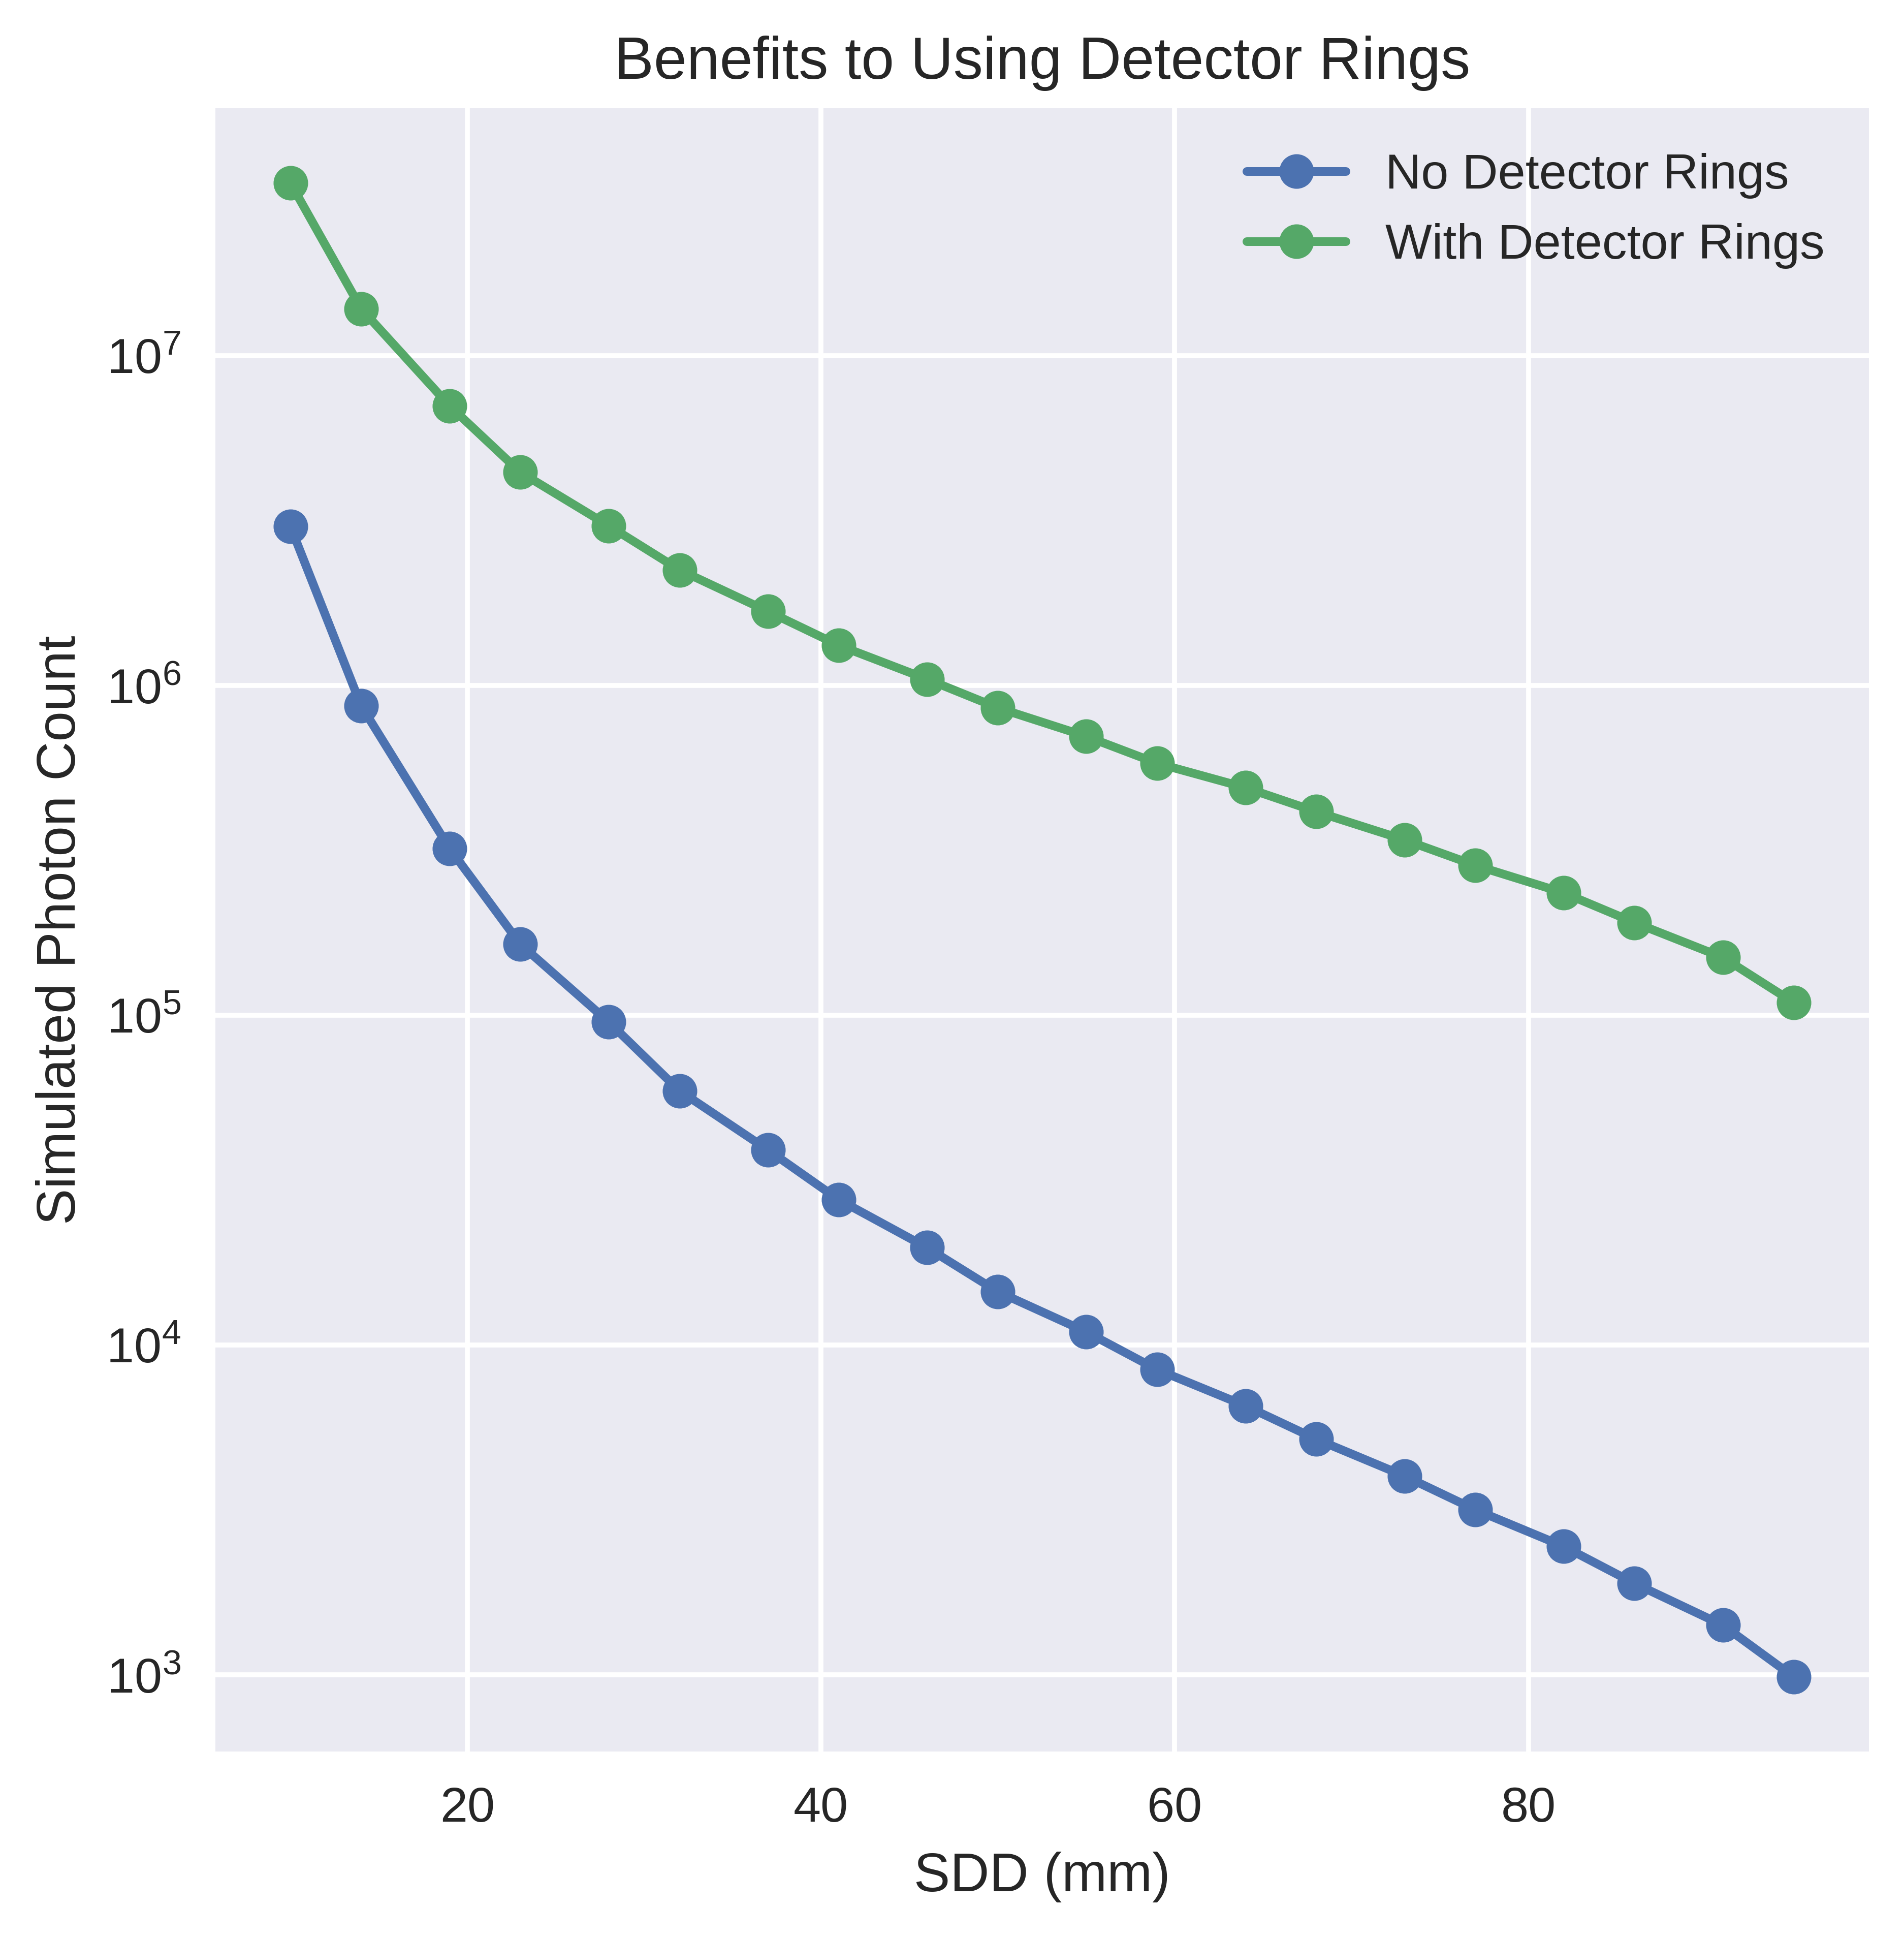

In [13]:
# Run the things above first
plt.style.use('seaborn')

photon_count = np.array(photon_count)

plt.figure(figsize=(6, 6), dpi=700)
plt.title("Photon Count Increase with Detector Rings")
plt.plot(all_sdd, photon_count/EQUIDISTANCE_DETECTOR_COUNT, 'o-', label=f'No Detector Rings')
plt.plot(all_sdd, photon_count, 'o-', label=f'With Detector Rings')

plt.title("Benefits to Using Detector Rings")
plt.xlabel('SDD (mm)')
plt.ylabel('Simulated Photon Count')
plt.yscale('log')
plt.legend()
plt.show()